# Numerical Optimization Assignment 2
## Introduction
In this assignment, we expect you to be familiar with the Pytorch optimizer library. We are using the Rosenbrock function as the benchmark of our optimization algorithms again. Since this is a simple test on very small scale, CUDA is not needed. You need to install Pytorch to acquire the pre-defined optimizers.  
The library document link: https://pytorch.org/docs/stable/optim.html

## Task
1. (40%) Please try at least 4 different optimizers and observe the behavior of them, and try different hyperparameters and observe if they behave differently. (In case of L-BFGS, the parameters wrapped in this sample code won't work. If you want to try it anyway, you will need to write your own code.) Whether if your setting converges or not, please justify it by experiment or your hyperthesis.
2. (40%) Please write a concise report about your experiments and analysis. If you need to plot tables, please check the following link: https://www.tablesgenerator.com/markdown_tables
3. (20%) Please answer the following question in your report:  
    (a) What is the relation between SGD and GD(gradient descent) in our case, i.e. when the input is one-dimensional?  
    (b) Have you found effective way to set hyperparameters so they can iterate faster toward the minimum point?
4. Rename this notebook file by adding your student ID and upload it to eeclass platform. (ex. hw2_110xxxxxx.ipynb)

##  Advanced Technique: Learning rate scheduler
Another technique to find hyperparameter for learning rate is to perform scheduled adjestments of learning rate. This is called 'learning rate scheduler'. The adjestments here not only affected by current learning rate and momentum etc., but also the epoch number or step numbers. Usually, in these kind of method, we are presuming the optimal hyperparameters can be found by recognizing certain patterns, and we schedule the experiments to search the proper parameters in such manner. You can also apply these function in your code. The library document of learning rate scheduler is in the same link above.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

In [ ]:
def rosenbrock(tensor):
    # since pytorch uses tensor, we don't use built-in function here
    x, y = tensor
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

def execute_steps(func, initial_state, optimizer_class, optimizer_config, num_iter):
    x = torch.Tensor(initial_state).requires_grad_(True)
    optimizer = optimizer_class([x], **optimizer_config)
    steps = []
    steps = np.zeros((2, num_iter))
    steps[:, 0] = np.array(initial_state)
    last_f = torch.tensor([100., 100.])
    for i in range(0, num_iter):
        optimizer.zero_grad()
        f = func(x)
        f.backward(create_graph=True, retain_graph=True)
        torch.nn.utils.clip_grad_norm_(x, 1.0)
        optimizer.step()
        steps[:, i] = x.detach().numpy()
    return steps

def plot_rosenbrok(grad_iter, optimizer_name):
    x = np.linspace(-2, 2, 250)
    y = np.linspace(-1, 3, 250)
    minimum = (1.0, 1.0)

    X, Y = np.meshgrid(x, y)
    Z = rosenbrock([X, Y])

    iter_x, iter_y = grad_iter[0, :], grad_iter[1, :]

    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(1, 1, 1)
    ax.contour(X, Y, Z, 90, cmap='jet')
    ax.plot(iter_x, iter_y, color='r', marker='x')

    ax.set_title('{} with {} iterations'.format(optimizer_name, len(iter_x)))
    plt.plot(*minimum, 'gD')
    plt.plot(iter_x[-1], iter_y[-1], 'rD')
    plt.show()

In [ ]:
#測試迭代到第幾次會收斂
def when_converge(steps):
  for i in range(len(steps[0])):
    if np.abs(steps[0][i] - 1) < 0.01 and np.abs(steps[1][i] - 1) < 0.01:
      print('converged at: ' + str(i))
      break

In [ ]:
def printX(steps):
    iter_x, iter_y = steps[0, :], steps[1, :]
    i=0
    for x,y in zip(iter_x,iter_y):
        #print("iteration %d: [%.4f %.4f]" %(i,x,y))
        i+=1
    print("iteration %d: [%.4f %.4f]" %(i,x,y))

#SGD

##SGD，使用作業預設的超參數

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.SGD
tol=1e-2
steps = execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.2, 'momentum':0.2, 'weight_decay':0.1},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-1.76592886 -1.49126101 -1.21611917 ...  0.44777167  0.54932815
   0.45179629]
 [ 2.00833654  2.02396917  2.04788876 ...  0.42456385  0.29210272
   0.42882949]]


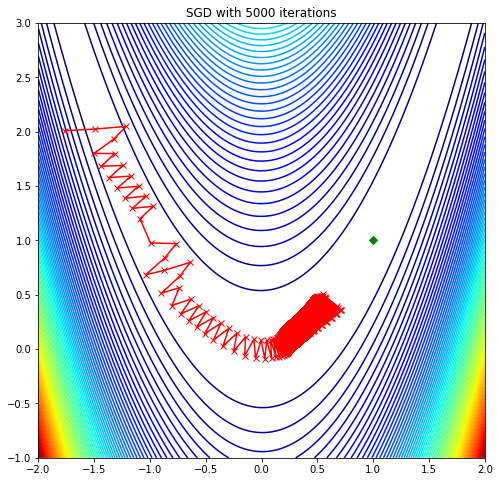

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [0.4518 0.4288]


##SGD，使用lr_scheduler.LambdaLR調整lr

In [ ]:
def LAMBDALR_execute_steps(func, initial_state, optimizer_class, optimizer_config, num_iter):
    x = torch.Tensor(initial_state).requires_grad_(True)
    optimizer = optimizer_class([x], **optimizer_config)
    steps = []
    steps = np.zeros((2, num_iter))
    steps[:, 0] = np.array(initial_state)
    last_f = torch.tensor([100., 100.])
    lambda1 = lambda epoch: epoch // 1680
    #lambda2 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
    for i in range(0, num_iter):
        optimizer.zero_grad()
        f = func(x)
        f.backward(create_graph=True, retain_graph=True)
        torch.nn.utils.clip_grad_norm_(x, 1.0)
        optimizer.step()
        steps[:, i] = x.detach().numpy()
        scheduler.step()
    return steps

initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.SGD
tol=1e-2
steps = LAMBDALR_execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.005, 'momentum':0.5, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-2.         -2.         -2.         ...  0.99511063  1.00107551
   0.99511087]
 [ 2.          2.          2.         ...  0.99400681  0.99102932
   0.99400717]]
converged at: 3683


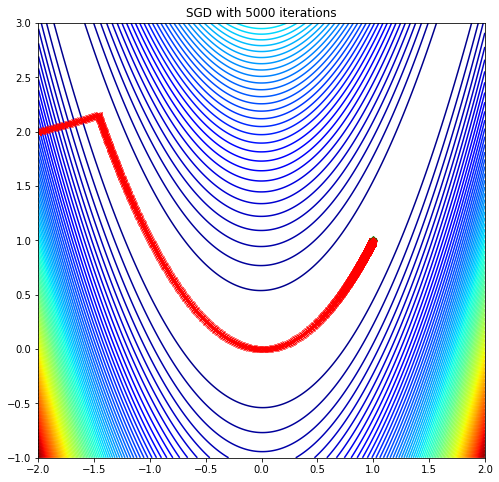

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [0.9951 0.9940]


###SGD，使用for迴圈以二分搜的方式，搜尋lr_scheduler.LambdaLR的最佳超參數

In [ ]:
for z in range(1650,1750,10):

  initial_state = np.array([-2,2])
  # TODO: Try other optimizers!
  optimizer_class = torch.optim.SGD
  tol=1e-2
  x = torch.Tensor(initial_state).requires_grad_(True)
  optimizer = optimizer_class([x], **{'lr':0.005, 'momentum':0.5, 'weight_decay':0})
  steps = []
  steps = np.zeros((2, 5000))
  steps[:, 0] = np.array(initial_state)
  last_f = torch.tensor([100., 100.])
  lambda1 = lambda epoch: epoch // z
  #lambda2 = lambda epoch: (0.01*z) ** epoch
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
  for i in range(0, 5000):
      optimizer.zero_grad()
      f = rosenbrock(x)
      f.backward(create_graph=True, retain_graph=True)
      torch.nn.utils.clip_grad_norm_(x, 1.0)
      optimizer.step()
      steps[:, i] = x.detach().numpy()
      scheduler.step()
  print(z)    
  printX(steps)

1650
iteration 5000: [0.9947 0.9932]
1660
iteration 5000: [0.9949 0.9937]
1670
iteration 5000: [0.9951 0.9940]
1680
iteration 5000: [0.9951 0.9940]
1690
iteration 5000: [0.9951 0.9940]
1700
iteration 5000: [0.9951 0.9940]
1710
iteration 5000: [0.9951 0.9940]
1720
iteration 5000: [0.9951 0.9940]
1730
iteration 5000: [0.9951 0.9940]
1740
iteration 5000: [0.9951 0.9940]


##SGD，使用指數衰減搜尋出的lr與momentum

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.SGD
tol=1e-2
steps = execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.003433683820292515, 'momentum':0.2, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-1.9966681  -1.99267018 -1.98853946 ...  0.99659038  0.99915123
   0.99659353]
 [ 2.00082994  2.001827    2.00285912 ...  0.99638009  0.99510348
   0.99638641]]
converged at: 3979


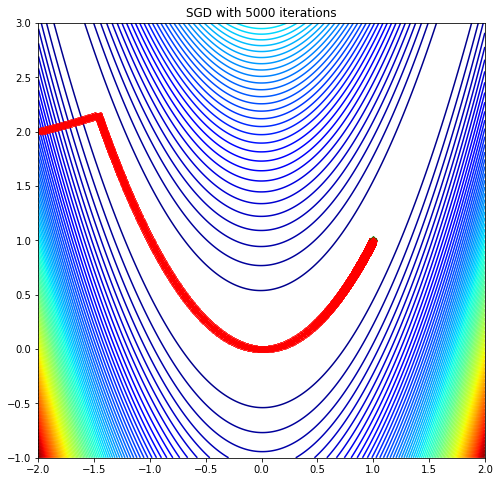

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [0.9966 0.9964]


###使用for迴圈以指數衰減的方式，直接搜尋SGD的最佳lr

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.SGD
#tol=1e-2
tol=10
for i in range(50):
  lr_test = 0.1*0.9**i
  steps = execute_steps(
          rosenbrock,
          initial_state,
          optimizer_class,
          # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
          {'lr':lr_test, 'momentum':0.2, 'weight_decay':0},
          num_iter=5000,
  )
  #print(i)
  #print(steps)
  if np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1]) < tol:
    tol = np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1])
    best_lr = lr_test

print('tol: ',tol)  
print('best_lr: ',best_lr)
#print('------------------------------------------')
#print(steps)

tol:  0.004966089556137019
best_lr:  0.003433683820292515


###使用for迴圈以指數衰減的方式，直接搜尋SGD的最佳momentum

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.SGD
#tol=1e-2
tol=10
for i in range(50):
  momentum_test = 0.2*0.9**i
  steps = execute_steps(
          rosenbrock,
          initial_state,
          optimizer_class,
          # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
          {'lr':best_lr, 'momentum':momentum_test, 'weight_decay':0},
          num_iter=5000,
  )
  #print(i)
  #print(steps)
  if np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1]) < tol:
    tol = np.linalg.norm([steps[0][4999] - 1,steps[1][4999] - 1])
    best_momentum = momentum_test

print('tol: ',tol)  
print('best_momentum: ',best_momentum)
#print('------------------------------------------')
#print(steps)

tol:  0.004966089556137019
best_momentum:  0.2


#Adam

##Adam，使用湊數找到的lr

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.Adam
tol=1e-2
steps = execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.005, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-1.995      -1.99000001 -1.98500001 ...  1.00003648  1.00009406
   0.99972063]
 [ 2.00500011  2.01000047  2.0150013  ...  0.99990022  0.99984711
   1.00016594]]
converged at: 1503


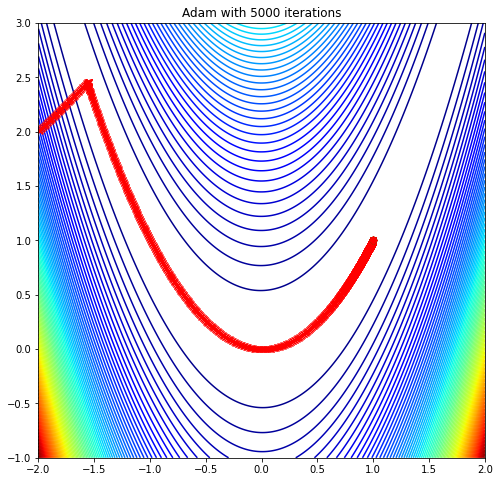

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [0.9997 1.0002]


##Adam，使用lr_scheduler.LambdaLR調整lr

In [ ]:
def LAMBDALR_execute_steps(func, initial_state, optimizer_class, optimizer_config, num_iter):
    x = torch.Tensor(initial_state).requires_grad_(True)
    optimizer = optimizer_class([x], **optimizer_config)
    steps = []
    steps = np.zeros((2, num_iter))
    steps[:, 0] = np.array(initial_state)
    last_f = torch.tensor([100., 100.])
    lambda1 = lambda epoch: epoch // 201
    #lambda2 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
    for i in range(0, num_iter):
        optimizer.zero_grad()
        f = func(x)
        f.backward(create_graph=True, retain_graph=True)
        torch.nn.utils.clip_grad_norm_(x, 1.0)
        optimizer.step()
        steps[:, i] = x.detach().numpy()
        scheduler.step()
    return steps

initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.Adam
tol=1e-2
steps = LAMBDALR_execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.005, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-2.         -2.         -2.         ...  0.99414814  1.00048423
   0.99414814]
 [ 2.          2.          2.         ...  0.99282968  0.98649573
   0.99282968]]
converged at: 847


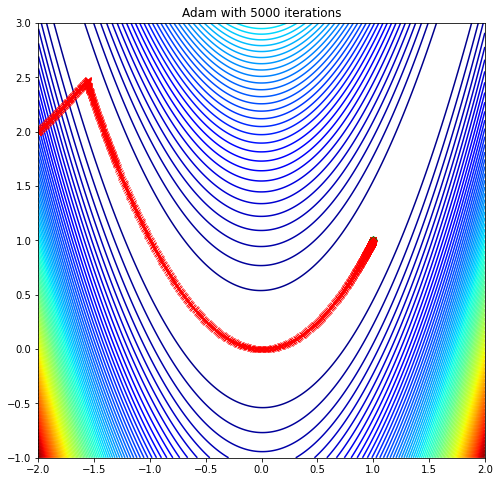

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [0.9941 0.9928]


###Adam，使用for迴圈以二分搜的方式，搜尋lr_scheduler.LambdaLR的最佳超參數

In [ ]:
for z in range(200,220,1):

  initial_state = np.array([-2,2])
  # TODO: Try other optimizers!
  optimizer_class = torch.optim.Adam
  tol=1e-2
  x = torch.Tensor(initial_state).requires_grad_(True)
  optimizer = optimizer_class([x], **{'lr':0.005, 'weight_decay':0})
  steps = []
  steps = np.zeros((2, 5000))
  steps[:, 0] = np.array(initial_state)
  last_f = torch.tensor([100., 100.])
  lambda1 = lambda epoch: epoch // z
  #lambda2 = lambda epoch: (0.01*z) ** epoch
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
  for i in range(0, 5000):
      optimizer.zero_grad()
      f = rosenbrock(x)
      f.backward(create_graph=True, retain_graph=True)
      torch.nn.utils.clip_grad_norm_(x, 1.0)
      optimizer.step()
      steps[:, i] = x.detach().numpy()
      scheduler.step()
  print(z)    
  printX(steps)

200
iteration 5000: [0.9974 0.9269]
201
iteration 5000: [0.9941 0.9928]
202
iteration 5000: [0.9614 0.9501]
203
iteration 5000: [0.9899 0.9273]
204
iteration 5000: [0.9921 0.9867]
205
iteration 5000: [0.9834 0.9750]
206
iteration 5000: [0.9862 0.9775]
207
iteration 5000: [0.9960 0.9626]
208
iteration 5000: [0.9909 0.9568]
209
iteration 5000: [1.0008 0.9694]
210
iteration 5000: [0.9967 0.9648]
211
iteration 5000: [0.9841 0.9748]
212
iteration 5000: [0.9920 0.9865]
213
iteration 5000: [0.9977 0.9664]
214
iteration 5000: [0.9845 0.9769]
215
iteration 5000: [0.9987 0.9662]
216
iteration 5000: [0.9919 0.9864]
217
iteration 5000: [0.9970 0.9668]
218
iteration 5000: [0.9989 0.9682]
219
iteration 5000: [0.9846 0.9774]


##Adam，使用指數衰減搜尋出的lr

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.Adam
tol=1e-2
steps = execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.0045000000000000005, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-1.99549997 -1.99099994 -1.98650002 ...  1.          1.
   1.        ]
 [ 2.00449991  2.00900006  2.01350069 ...  1.          1.
   1.        ]]
converged at: 1660


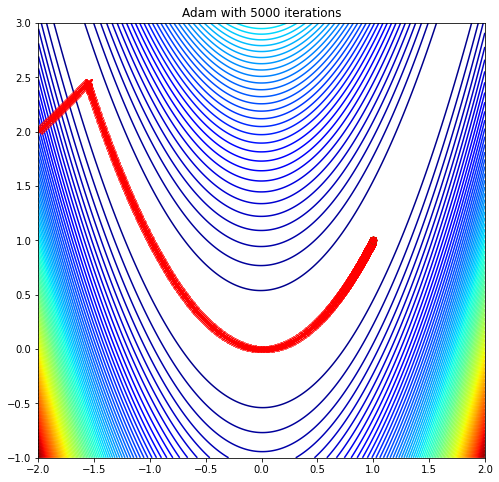

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [1.0000 1.0000]


###Adam，使用for迴圈以指數衰減的方式，直接搜尋Adam的最佳lr

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.Adam
#tol=1e-2
tol=10
for i in range(50):
  lr_test = 0.005*0.9**i
  steps = execute_steps(
          rosenbrock,
          initial_state,
          optimizer_class,
          # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
          {'lr':lr_test, 'weight_decay':0},
          num_iter=5000,
      )
  #print(i)
  #print(steps)
  if np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1]) < tol:
    tol = np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1])
    best_lr = lr_test

print('tol: ',tol)  
print('best_lr: ',best_lr)
#print('------------------------------------------')
#print(steps)

tol:  0.0
best_lr:  0.0045000000000000005


#ASGD

##ASGD，使用湊數找到的lr與lambd

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.ASGD
tol=1e-2
steps = execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.005, 'lambd':0.00001, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-1.99514806 -1.99029684 -1.98544633 ...  0.99299836  0.98853922
   0.99300927]
 [ 2.00120831  2.00241923  2.00363278 ...  0.98060673  0.98286659
   0.98062849]]


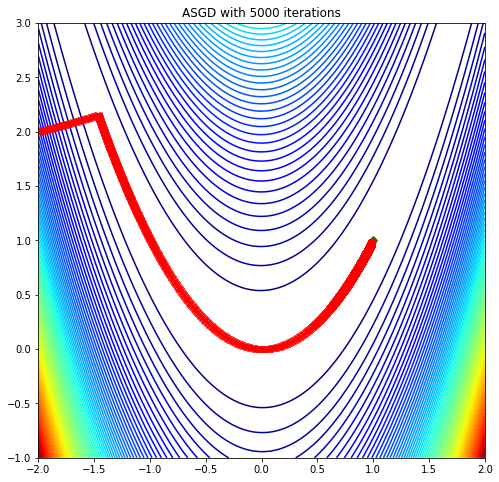

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [0.9930 0.9806]


##ASGD，使用lr_scheduler.LambdaLR調整lr

In [ ]:
def LAMBDALR_execute_steps(func, initial_state, optimizer_class, optimizer_config, num_iter):
    x = torch.Tensor(initial_state).requires_grad_(True)
    optimizer = optimizer_class([x], **optimizer_config)
    steps = []
    steps = np.zeros((2, num_iter))
    steps[:, 0] = np.array(initial_state)
    last_f = torch.tensor([100., 100.])
    lambda1 = lambda epoch: epoch // 1600
    #lambda2 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
    for i in range(0, num_iter):
        optimizer.zero_grad()
        f = func(x)
        f.backward(create_graph=True, retain_graph=True)
        torch.nn.utils.clip_grad_norm_(x, 1.0)
        optimizer.step()
        steps[:, i] = x.detach().numpy()
        scheduler.step()
    return steps

initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.ASGD
tol=1e-2
steps = LAMBDALR_execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.005, 'lambd':0.00001, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-2.         -2.         -2.         ...  0.97614652  0.96281815
   0.97617745]
 [ 2.          2.          2.         ...  0.92985201  0.93671525
   0.92991281]]


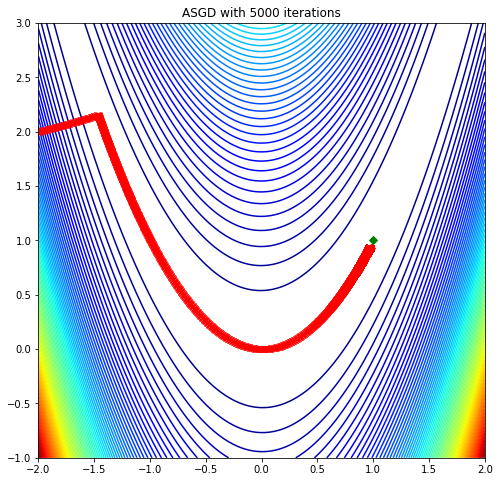

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [0.9762 0.9299]


###ASGD，使用for迴圈以二分搜的方式，搜尋lr_scheduler.LambdaLR的最佳超參數

In [ ]:
for z in range(1000,3000,50):

  initial_state = np.array([-2,2])
  # TODO: Try other optimizers!
  optimizer_class = torch.optim.ASGD
  tol=1e-2
  x = torch.Tensor(initial_state).requires_grad_(True)
  optimizer = optimizer_class([x], **{'lr':0.005, 'lambd':0.00001, 'weight_decay':0})
  steps = []
  steps = np.zeros((2, 5000))
  steps[:, 0] = np.array(initial_state)
  last_f = torch.tensor([100., 100.])
  lambda1 = lambda epoch: epoch // z
  #lambda2 = lambda epoch: (0.01*z) ** epoch
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
  for i in range(0, 5000):
      optimizer.zero_grad()
      f = rosenbrock(x)
      f.backward(create_graph=True, retain_graph=True)
      torch.nn.utils.clip_grad_norm_(x, 1.0)
      optimizer.step()
      steps[:, i] = x.detach().numpy()
      scheduler.step()
  print(z)    
  printX(steps)

1000
iteration 5000: [0.9761 0.9216]
1050
iteration 5000: [0.9765 0.9221]
1100
iteration 5000: [0.9772 0.9234]
1150
iteration 5000: [0.9527 0.9396]
1200
iteration 5000: [0.9792 0.9268]
1250
iteration 5000: [0.9761 0.9317]
1300
iteration 5000: [0.9590 0.9412]
1350
iteration 5000: [0.9587 0.9408]
1400
iteration 5000: [0.9584 0.9404]
1450
iteration 5000: [0.9582 0.9403]
1500
iteration 5000: [0.9580 0.9403]
1550
iteration 5000: [0.9761 0.9300]
1600
iteration 5000: [0.9762 0.9299]
1650
iteration 5000: [0.9577 0.9405]
1700
iteration 5000: [0.9716 0.9314]
1750
iteration 5000: [0.9609 0.9362]
1800
iteration 5000: [0.9600 0.9348]
1850
iteration 5000: [0.9698 0.9270]
1900
iteration 5000: [0.9690 0.9253]
1950
iteration 5000: [0.9682 0.9235]
2000
iteration 5000: [0.9672 0.9214]
2050
iteration 5000: [0.9547 0.9257]
2100
iteration 5000: [0.9533 0.9231]
2150
iteration 5000: [0.9517 0.9203]
2200
iteration 5000: [0.9617 0.9099]
2250
iteration 5000: [0.9478 0.9132]
2300
iteration 5000: [0.9577 0.9019]
2

##ASGD，使用指數衰減搜尋出的lr與lambd

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.ASGD
tol=1e-2
steps = execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.0045000000000000005, 'lambd':1.6423203268260677e-07, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-1.99563336 -1.99126732 -1.98690188 ...  0.98898125  0.99300623
   0.98899275]
 [ 2.00108767  2.00217748  2.00326943 ...  0.98304564  0.98103333
   0.98306847]]


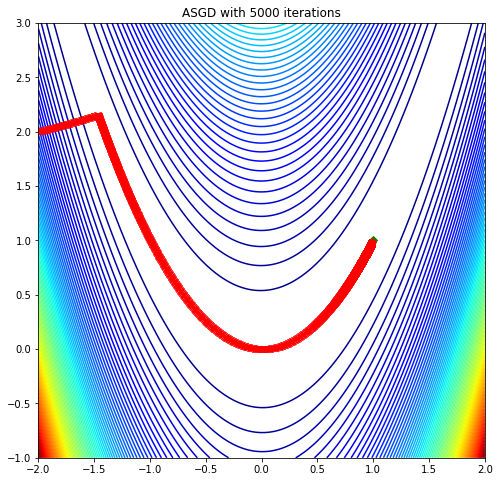

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [0.9890 0.9831]


###ASGD，使用for迴圈以指數衰減的方式，直接搜尋ASGD的最佳lr

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.ASGD
#tol=1e-2
tol=10
for i in range(50):
  lr_test = 0.005*0.9**i
  steps = execute_steps(
          rosenbrock,
          initial_state,
          optimizer_class,
          # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
          {'lr':lr_test, 'lambd':0.00001, 'weight_decay':0},
          num_iter=5000,
  )
  #print(i)
  #print(steps)
  if np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1]) < tol:
    tol = np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1])
    best_lr = lr_test

print('tol: ',tol)  
print('best_lr: ',best_lr)
#print('------------------------------------------')
#print(steps)

tol:  0.020293208380688384
best_lr:  0.0045000000000000005


###ASGD，使用for迴圈以指數衰減的方式，直接搜尋ASGD的最佳lambd

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.ASGD
#tol=1e-2
tol=10
for i in range(50):
  lambd_test = 0.00001*0.9**i
  steps = execute_steps(
          rosenbrock,
          initial_state,
          optimizer_class,
          # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
          {'lr':best_lr, 'lambd':lambd_test, 'weight_decay':0},
          num_iter=5000,
  )
  #print(i)
  #print(steps)
  if np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1]) < tol:
    tol = np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1])
    best_lambd = lambd_test

print('tol: ',tol)  
print('best_lambd: ',best_lambd)
#print('------------------------------------------')
#print(steps)

tol:  0.02019495916428177
best_lambd:  1.6423203268260677e-07


#Adamax

##Adamax，使用湊數找到的lr

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.Adamax
tol=1e-2
steps = execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.005, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-1.995      -1.98999965 -1.98499894 ...  1.00000131  1.0000006
   0.99999613]
 [ 2.00500011  2.00999475  2.01498413 ...  0.99999535  0.99999619
   1.00000072]]
converged at: 1631


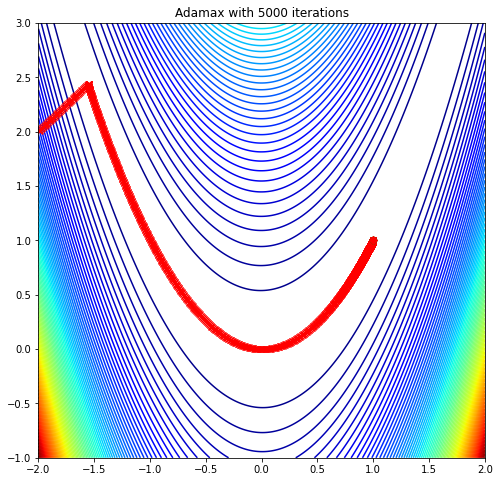

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [1.0000 1.0000]


##Adamax，使用lr_scheduler.LambdaLR調整lr

In [ ]:
def LAMBDALR_execute_steps(func, initial_state, optimizer_class, optimizer_config, num_iter):
    x = torch.Tensor(initial_state).requires_grad_(True)
    optimizer = optimizer_class([x], **optimizer_config)
    steps = []
    steps = np.zeros((2, num_iter))
    steps[:, 0] = np.array(initial_state)
    last_f = torch.tensor([100., 100.])
    lambda1 = lambda epoch: epoch // 1001
    #lambda2 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
    for i in range(0, num_iter):
        optimizer.zero_grad()
        f = func(x)
        f.backward(create_graph=True, retain_graph=True)
        torch.nn.utils.clip_grad_norm_(x, 1.0)
        optimizer.step()
        steps[:, i] = x.detach().numpy()
        scheduler.step()
    return steps

initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.Adamax
tol=1e-2
steps = LAMBDALR_execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.005, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-2.         -2.         -2.         ...  0.99999219  0.9999969
   0.99999392]
 [ 2.          2.          2.         ...  0.99999177  0.99998742
   0.99999076]]
converged at: 2352


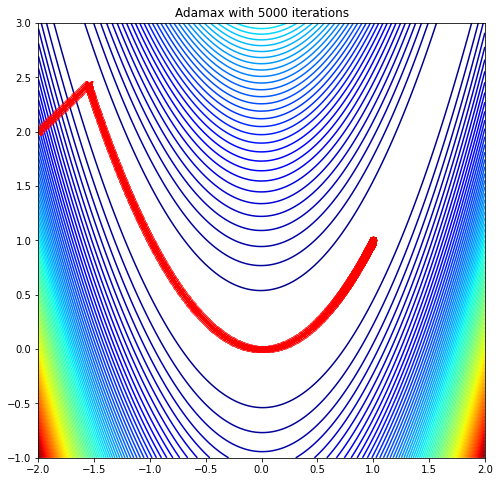

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [1.0000 1.0000]


###Adamax，使用for迴圈以二分搜的方式，搜尋lr_scheduler.LambdaLR的最佳超參數

In [ ]:
for z in range(1,1300,100):

  initial_state = np.array([-2,2])
  # TODO: Try other optimizers!
  optimizer_class = torch.optim.Adamax
  tol=1e-2
  x = torch.Tensor(initial_state).requires_grad_(True)
  optimizer = optimizer_class([x], **{'lr':0.005, 'weight_decay':0})
  steps = []
  steps = np.zeros((2, 5000))
  steps[:, 0] = np.array(initial_state)
  last_f = torch.tensor([100., 100.])
  lambda1 = lambda epoch: epoch // z
  #lambda2 = lambda epoch: (0.01*z) ** epoch
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
  for i in range(0, 5000):
      optimizer.zero_grad()
      f = rosenbrock(x)
      f.backward(create_graph=True, retain_graph=True)
      torch.nn.utils.clip_grad_norm_(x, 1.0)
      optimizer.step()
      steps[:, i] = x.detach().numpy()
      scheduler.step()
  print(z)    
  printX(steps)

1
iteration 5000: [2.5442 4.9312]
101
iteration 5000: [0.7907 0.6815]
201
iteration 5000: [0.9595 0.8844]
301
iteration 5000: [1.0002 0.9797]
401
iteration 5000: [0.9853 0.9276]
501
iteration 5000: [0.9884 0.9852]
601
iteration 5000: [0.9952 0.9823]
701
iteration 5000: [0.9982 0.9869]
801
iteration 5000: [0.9923 0.9988]
901
iteration 5000: [1.0005 0.9905]
1001
iteration 5000: [1.0000 1.0000]
1101
iteration 5000: [0.9998 1.0001]
1201
iteration 5000: [1.0000 1.0000]


##Adamax，使用指數衰減搜尋出的lr

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.Adamax
tol=1e-2
steps = execute_steps(
        rosenbrock,
        initial_state,
        optimizer_class,
        # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
        {'lr':0.0023914845000000003, 'weight_decay':0},
        num_iter=5000,
    )
print(steps)
when_converge(steps)

[[-1.99760854 -1.99521697 -1.99282527 ...  0.99999994  0.99999994
   0.99999988]
 [ 2.00239158  2.00478172  2.00717068 ...  0.99999982  0.99999982
   0.99999988]]
converged at: 2832


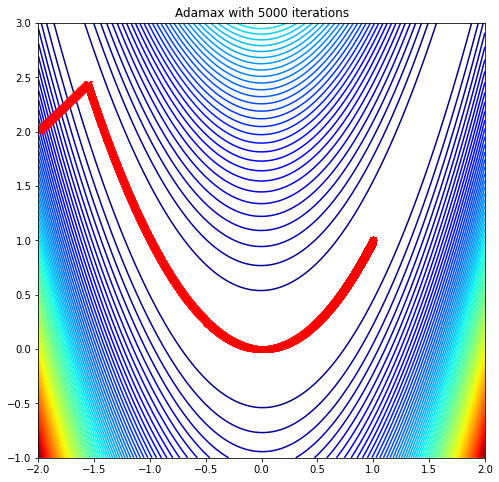

In [ ]:
plot_rosenbrok(steps, optimizer_class.__name__)

In [ ]:
printX(steps)

iteration 5000: [1.0000 1.0000]


###Adamax，使用for迴圈以指數衰減的方式，直接搜尋Adamax的最佳lr

In [ ]:
initial_state = np.array([-2,2])
# TODO: Try other optimizers!
optimizer_class = torch.optim.Adamax
#tol=1e-2
tol=10
for i in range(50):
  lr_test = 0.005*0.9**i
  steps = execute_steps(
          rosenbrock,
          initial_state,
          optimizer_class,
          # TODO: Try some different hyperparameters! Note that these parameters should be wraped in a dict().
          {'lr':lr_test, 'weight_decay':0},
          num_iter=5000,
  )
  #print(i)
  #print(steps)
  if np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1]) < tol:
    tol = np.linalg.norm([steps[0][4999] - 1, steps[1][4999] - 1])
    best_lr = lr_test

print('tol: ',tol)  
print('best_lr: ',best_lr)
#print('------------------------------------------')
#print(steps)

tol:  1.6858739404357614e-07
best_lr:  0.0023914845000000003


# Report

這次作業我總共使用了四種優化器(optimizers)來測試，分別是SGD、Adam、ASGD和Adamax，而四種優化器也各使用了兩種尋找最佳超參數的方法，分別是pytorch函式庫中內建的lr_scheduler.LambdaLR和指數衰減。

##SGD，使用作業預設的超參數，

使用的參數為{'lr':0.2, 'momentum':0.2, 'weight_decay':0.1}，並不能收斂到解的位置。

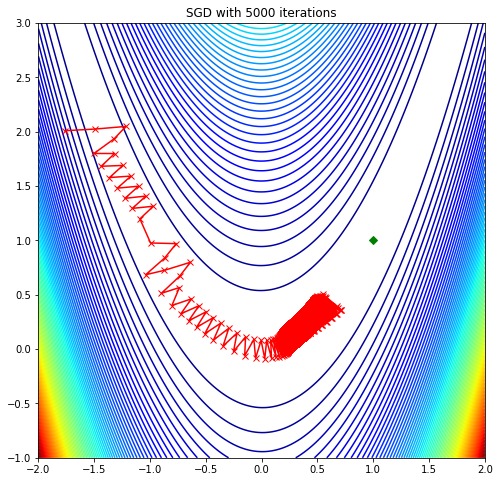

##SGD，使用lr_scheduler.LambdaLR調整lr，

在第3683次迭代可以收斂到tol<0.01，最終收斂在[0.9951 0.9940]。

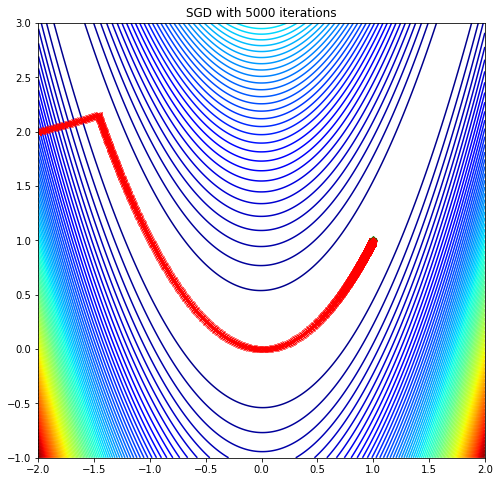


##SGD，使用指數衰減搜尋出的lr與momentum，

使用的參數為{'lr':0.003433683820292515, 'momentum':0.2, 'weight_decay':0}，

在第3979次迭代可以收斂到tol<0.01，最終收斂在[0.9966 0.9964]。

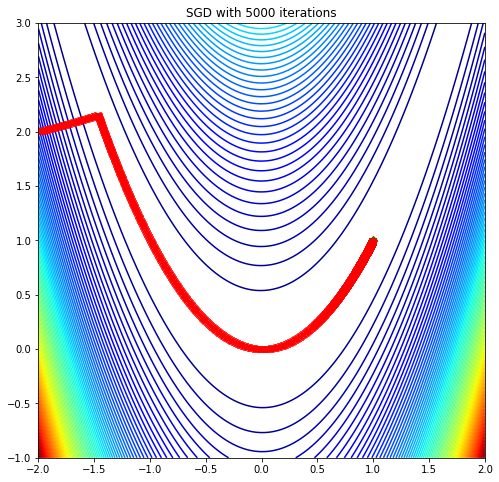

##Adam，使用湊數找到的lr，

使用的參數為{'lr':0.005, 'weight_decay':0}，

在第1503次迭代可以收斂到tol<0.01，最終收斂在[0.9997 1.0002]。

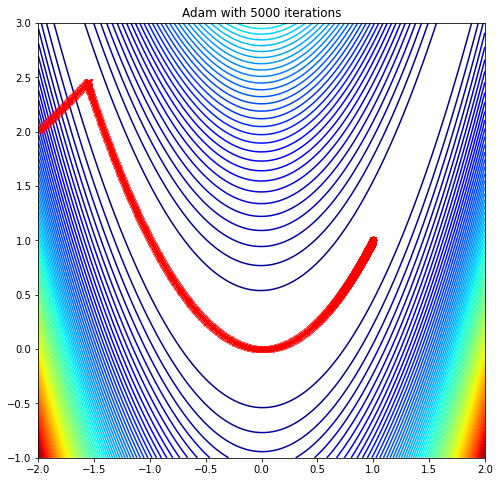

##Adam，使用lr_scheduler.LambdaLR調整lr，

在第847次迭代可以收斂到tol<0.01，最終收斂在[0.9941 0.9928]。

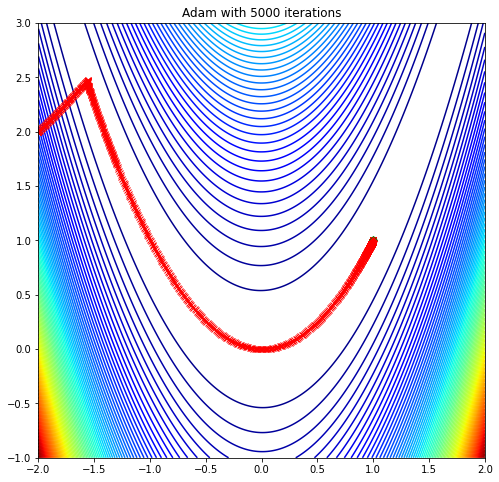

##Adam，使用指數衰減搜尋出的lr，

使用的參數為{'lr':0.0045000000000000005, 'weight_decay':0}，

在第1660次迭代可以收斂到tol<0.01，最終收斂在[1.0000 1.0000]。

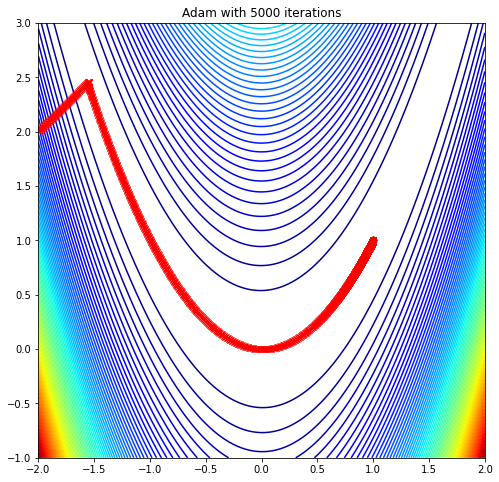

##ASGD，使用湊數找到的lr與lambd，

使用的參數為{'lr':0.005, 'lambd':0.00001, 'weight_decay':0}，

最終收斂在[0.9930 0.9806]。

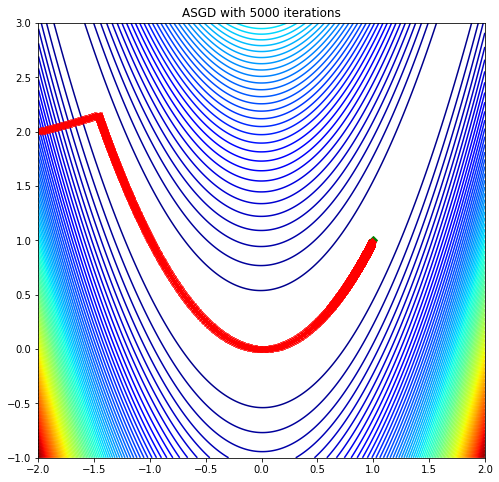

##ASGD，使用lr_scheduler.LambdaLR調整lr，

最終收斂在[0.9762 0.9299]。

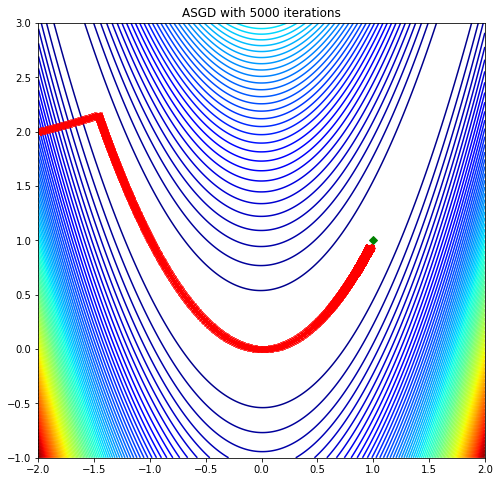

##ASGD，使用指數衰減搜尋出的lr與lambd，

使用的參數為{'lr':0.0045000000000000005, 'lambd':1.6423203268260677e-07, 'weight_decay':0}，

最終收斂在[0.9890 0.9831]。

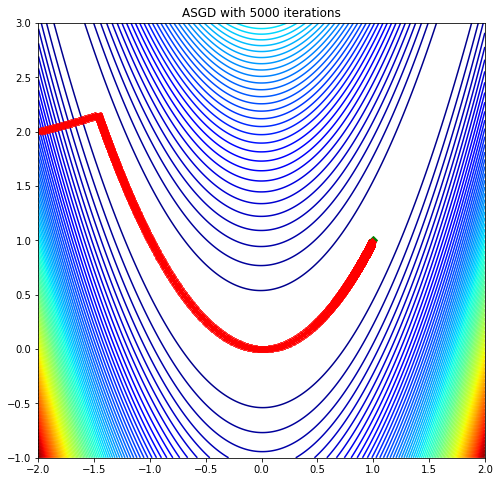

##Adamax，使用湊數找到的lr，

使用的參數為{'lr':0.005, 'weight_decay':0}，

在第1631次迭代可以收斂到tol<0.01，最終收斂在[1.0000 1.0000]。

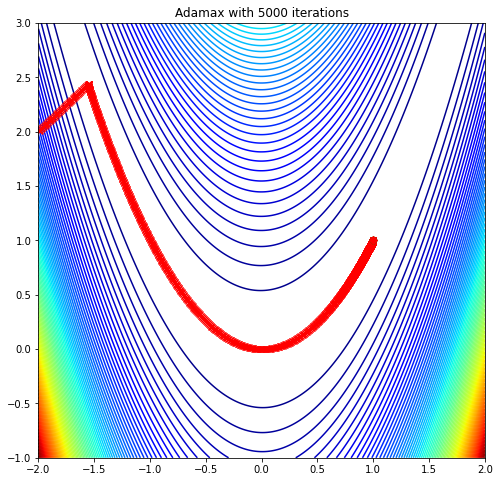

##Adamax，使用lr_scheduler.LambdaLR調整lr，

在第2352次迭代可以收斂到tol<0.01，最終收斂在[1.0000 1.0000]。

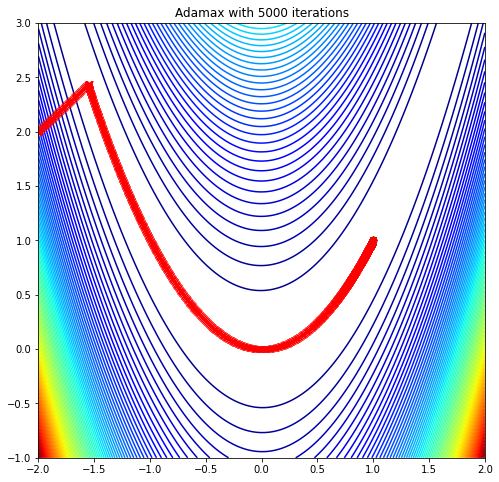

##Adamax，使用指數衰減搜尋出的lr，

使用的參數為{'lr':0.0023914845000000003, 'weight_decay':0}，

在第2832次迭代可以收斂到tol<0.01，最終收斂在[1.0000 1.0000]。

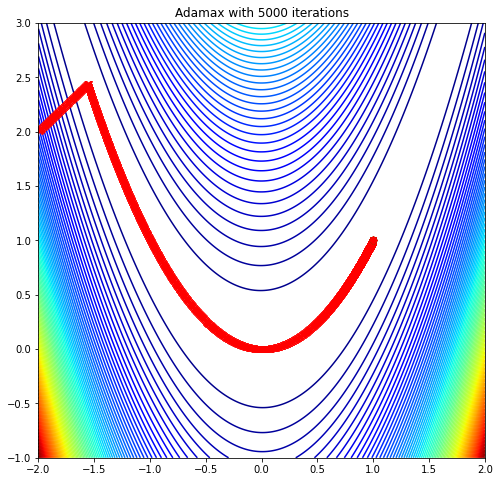

在四種優化器與各自的超參數選擇結果中，Adam使用指數衰減找到的lr 和 Adamax 都可以完美地收斂在[1, 1]。

##3.(a) What is the relation between SGD and GD(gradient descent) in our case, i.e. when the input is one-dimensional?

GD是每次迭代都要跑過全部的train資料來更新參數，

而SGD是將train資料分成很多batch，再透過這些很多的batch更新。

但當資料為一維時，SGD將train資料分成一個batch，就像沒有分一樣，GD和SGD的表現應是一樣的。

##3.(b) Have you found effective way to set hyperparameters so they can iterate faster toward the minimum point?

在尋找超參數方面，我使用了pytorch函式庫中內建的lr_scheduler.LambdaLR和自己寫的指數衰減，

lr_scheduler.LambdaLR是使用for迴圈搭配二分搜找出其中的最佳參數lambda1，

指數衰減則是使用for迴圈遍歷數值直接找出最佳的優化器超參數。

而weight_decay在經過幾次測試後發現並不會影響收斂結果太多，一般使用weight_decay=0.01，我則是使用0。